<a href="https://colab.research.google.com/github/victoraccete/us-accidents/blob/main/Estat%C3%ADstica_Inferencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kaggle
from scipy.stats import norm
from scipy.stats import t
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [ ]:
#@title Upload yout API token. 
#@markdown Check [here](https://github.com/Kaggle/kaggle-api#:~:text=API%20credentials,file%20containing%20your%20API%20credentials.) to see how to get it.
# importing kaggle.json to use the api 
from google.colab import files
files.upload()
; # suppressing output to hide API informations

Saving kaggle.json to kaggle.json


'# suppressing output to hide API informations'

In [ ]:
#@title Download dataset from Kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
;
!kaggle datasets download -d sobhanmoosavi/us-accidents

 97% 281M/290M [00:03<00:00, 77.0MB/s]
100% 290M/290M [00:03<00:00, 76.5MB/s]


In [ ]:
#@title Unzipping
# zip extraction cell
import zipfile
zip_ref = zipfile.ZipFile('us-accidents.zip', 'r')
zip_ref.extractall('../content')
zip_ref.close()

## Done

In [2]:
import pandas as pd
accidents = pd.read_csv('US_Accidents_Dec20_Updated.csv')
accidents.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,2,2019-05-21 08:29:55,2019-05-21 09:29:40,34.808868,-82.269157,34.808868,-82.269157,0.0,Accident on Tanner Rd at Pennbrooke Ln.,439.0,Tanner Rd,R,Greenville,Greenville,SC,29607-6027,US,US/Eastern,KGMU,2019-05-21 08:53:00,76.0,76.0,52.0,28.91,10.0,N,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2,2,2019-10-07 17:43:09,2019-10-07 19:42:50,35.090080,-80.745560,35.090080,-80.745560,0.0,Accident on Houston Branch Rd at Providence Br...,3299.0,Providence Branch Ln,R,Charlotte,Mecklenburg,NC,28270-8560,US,US/Eastern,KEQY,2019-10-07 17:53:00,76.0,76.0,62.0,29.30,10.0,VAR,3.0,0.0,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3,2,2020-12-13 21:53:00,2020-12-13 22:44:00,37.145730,-121.985052,37.165850,-121.988062,1.4,Stationary traffic on CA-17 from Summit Rd (CA...,NaN,Santa Cruz Hwy,R,Los Gatos,Santa Clara,CA,95033,US,US/Pacific,KSJC,2020-12-13 21:53:00,51.0,51.0,80.0,30.17,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
3,A-4,2,2018-04-17 16:51:23,2018-04-17 17:50:46,39.110390,-119.773781,39.110390,-119.773781,0.0,Accident on US-395 Southbound at Topsy Ln.,NaN,US Highway 395 S,R,Carson City,Douglas,NV,89705,US,US/Pacific,KCXP,2018-04-17 16:55:00,53.6,NaN,16.0,30.16,10.0,SSW,4.6,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
4,A-5,3,2016-08-31 17:40:49,2016-08-31 18:10:49,26.102942,-80.265091,26.102942,-80.265091,0.0,Accident on I-595 Westbound at Exit 4 / Pine I...,NaN,I-595 W,R,Fort Lauderdale,Broward,FL,33324,US,US/Eastern,KHWO,2016-08-31 17:53:00,84.2,NaN,84.0,29.92,10.0,SSE,13.8,NaN,Overcast,False,False,False,False,True,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906610 entries, 0 to 2906609
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

In [ ]:
accidents.isna().sum()

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                   282821
End_Lng                   282821
Distance(mi)                   0
Description                    0
Number                   1891672
Street                         0
Side                           0
City                         108
County                         0
State                          0
Zipcode                     1114
Country                        0
Timezone                    3430
Airport_Code                6608
Weather_Timestamp          46917
Temperature(F)             67224
Wind_Chill(F)            1183859
Humidity(%)                71270
Pressure(in)               56908
Visibility(mi)             72078
Wind_Direction             63474
Wind_Speed(mph)           307163
Precipitation(in)        1301326
Weather_Condition          71851
Amenity   

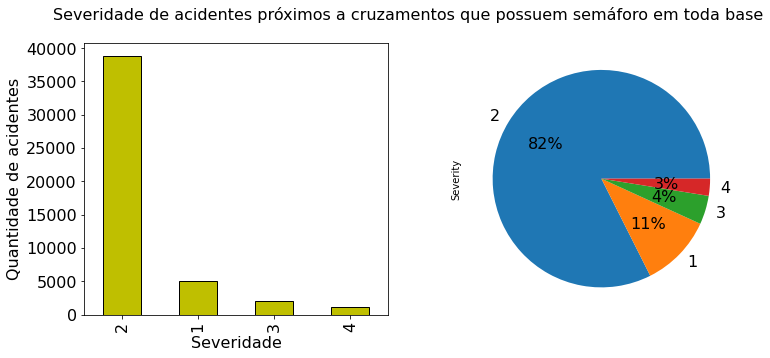

In [68]:
#Accidents on crossings
data_crossing = accidents[accidents['Crossing'] == True].dropna()

plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes próximos a cruzamentos que possuem semáforo em toda base',fontsize=16)
plt.subplot(1,2,1)
data_crossing.loc[data_crossing['Traffic_Signal'] == True]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
data_crossing.loc[data_crossing['Traffic_Signal'] == True]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

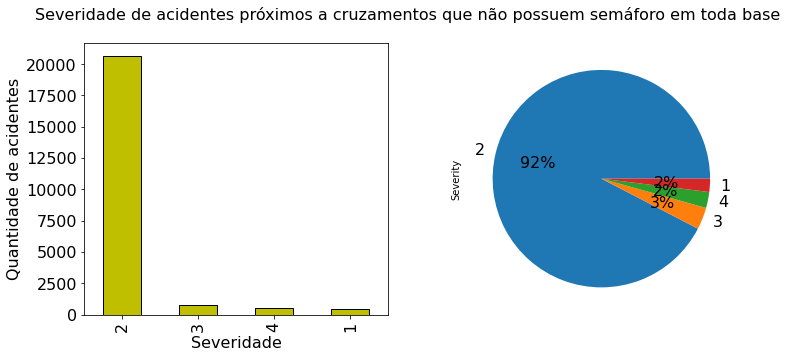

In [69]:
plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes próximos a cruzamentos que não possuem semáforo em toda base',fontsize=16)
plt.subplot(1,2,1)
data_crossing.loc[data_crossing['Traffic_Signal'] == False]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
data_crossing.loc[data_crossing['Traffic_Signal'] == False]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

Necessita-se balancear os dados e extrair amostra randomizada

In [3]:
filter_columns = ['Severity', 'Crossing', 'Traffic_Signal']
new_df = accidents[filter_columns]

print(new_df['Severity'][new_df['Severity'] == 1].dropna().count())
print(new_df['Severity'][new_df['Severity'] == 2].dropna().count())
print(new_df['Severity'][new_df['Severity'] == 3].dropna().count())
print(new_df['Severity'][new_df['Severity'] == 4].dropna().count())

lower_number = new_df['Severity'][new_df['Severity'] == 1].dropna().count()
severity1 = new_df[new_df['Severity'] == 1].dropna().sample(n=lower_number, random_state=1)
severity2 = new_df[new_df['Severity'] == 2].dropna().sample(n=lower_number, random_state=1)
severity3 = new_df[new_df['Severity'] == 3].dropna().sample(n=lower_number, random_state=1)
severity4 = new_df[new_df['Severity'] == 4].dropna().sample(n=lower_number, random_state=1)

features = pd.concat([severity1, severity2, severity3, severity4])

28751
2129263
629452
119144


In [10]:
df_crossing = features[features['Crossing'] == True]
df_crossing_and_signal = df_crossing[df_crossing['Traffic_Signal'] == True]

df3 = pd.merge(features, df_crossing_and_signal, how='outer', indicator='Exist')
df_no_crossing_and_signal = df3[df3['Exist'] != 'both']


df_crossing_and_signal['evaluation'] = df_crossing_and_signal.apply(lambda row: 1, axis = 1)
df_no_crossing_and_signal['evaluation'] = df_no_crossing_and_signal.apply(lambda row: 0, axis = 1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [37]:
df_no_crossing_and_signal.head()

,Severity,Crossing,Traffic_Signal,Exist,evaluation
0,1,False,False,left_only,False
1,1,False,False,left_only,False
2,1,False,False,left_only,False
3,1,False,False,left_only,False
4,1,False,False,left_only,False


In [38]:
df_crossing_and_signal.head()

,Severity,Crossing,Traffic_Signal,evaluation
1184680,1,True,True,True
1963234,1,True,True,True
1195301,1,True,True,True
450846,1,True,True,True
1778600,1,True,True,True


In [11]:
df_crossing = pd.concat([df_crossing_and_signal, df_no_crossing_and_signal]).sample(n=383, random_state=1)

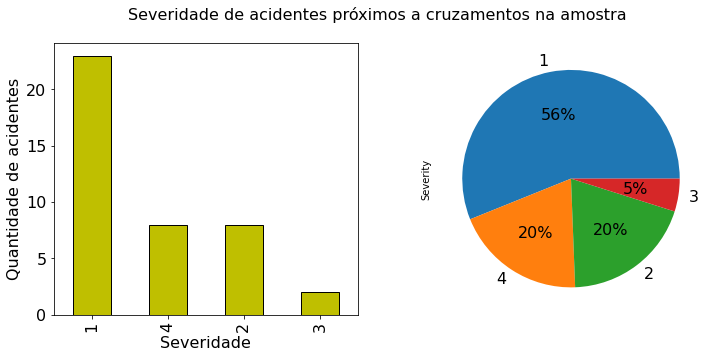

In [65]:
plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes próximos a cruzamentos na amostra',fontsize=16)
plt.subplot(1,2,1)
df_crossing.loc[df_crossing['Crossing'] == True]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
df_crossing.loc[df_crossing['Crossing'] == True]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

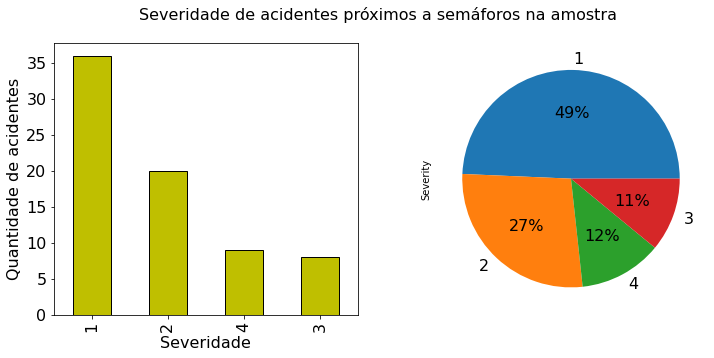

In [66]:
plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes próximos a semáforos na amostra',fontsize=16)
plt.subplot(1,2,1)
df_crossing.loc[df_crossing['Traffic_Signal'] == True]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
df_crossing.loc[df_crossing['Traffic_Signal'] == True]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

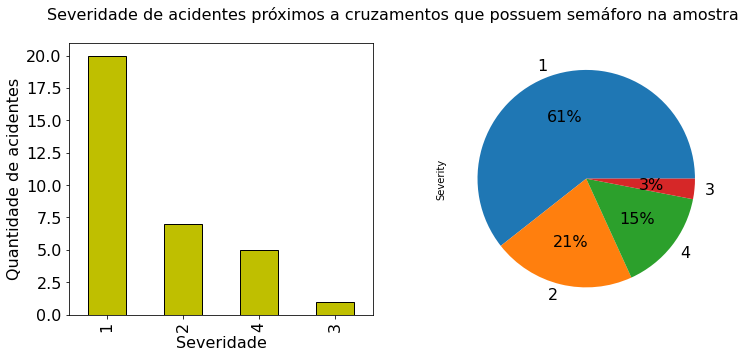

In [19]:
plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes próximos a cruzamentos que possuem semáforo na amostra',fontsize=16)
plt.subplot(1,2,1)
df_crossing.loc[df_crossing['evaluation'] == 1]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
df_crossing.loc[df_crossing['evaluation'] == 1]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

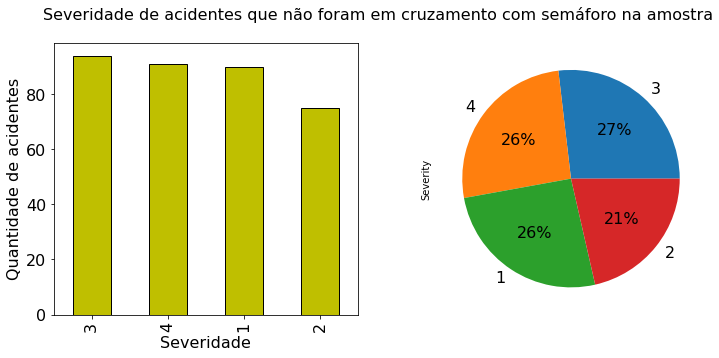

In [20]:
plt.subplots(1,2,figsize=(12,5))
plt.xticks(fontsize=14)
plt.suptitle('Severidade de acidentes que não foram em cruzamento com semáforo na amostra',fontsize=16)
plt.subplot(1,2,1)
df_crossing.loc[df_crossing['evaluation'] == 0]['Severity'].value_counts().plot.bar(width=0.5,color='y',edgecolor='k',align='center',linewidth=1)
plt.xlabel('Severidade',fontsize=16)
plt.ylabel('Quantidade de acidentes',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(1,2,2)
df_crossing.loc[df_crossing['evaluation'] == 0]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

x = np.array(df_crossing['Severity']).reshape(-1, 1)
y = df_crossing['evaluation']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

res = sm.Logit(y_train, x_train).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.244186
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             evaluation   No. Observations:                  306
Model:                          Logit   Df Residuals:                      305
Method:                           MLE   Df Model:                            0
Date:                Tue, 18 May 2021   Pseudo R-squ.:                 0.08474
Time:                        04:44:23   Log-Likelihood:                -74.721
converged:                       True   LL-Null:                       -81.639
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2356      0.130     -9.490      0.000      -1.491      -0.980
